In [2]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
#from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggMapNet, loadmap
from aggmap.AggMapNet import load_model, save_model
from aggmap import show


np.random.seed(666) #just for reaptable results


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_pred

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return auc, mcc, pres, recall, f1

In [3]:
task = 'IBD'
data_path = '../../01_data/species_level/%s/' % (task)
save_dir = 'mapping_%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'ibd':1, 'n':0}))
Y = dfy.values

In [4]:
C = 10
random_state = 123
repeat_seeds = [8, 16, 32, 64, 128, 256, 1024, 2048, 4096, 8192]
conv1_kernel_size = 13
epochs = 50

dfx = np.log(dfa.T + 1e-2)
mp = AggMap(dfx, metric= 'correlation')

2022-01-17 17:13:33,374 - INFO - [bidd-aggmap] - Calculating distance ...
2022-01-17 17:13:33,388 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 443/443 [00:00<00:00, 981.17it/s]


# UMAP Method

In [ ]:
mp.fit(cluster_channels = C, emb_method='umap', verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_umap = mp.batch_transform(dfx.values)
df_umap = mp.df_embedding[['x','y','colors']]
dfg_umap = mp.df_grid[['x','y','colors']]

2022-01-17 17:13:39,035 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


# T-SNE Method

In [ ]:
mp.fit(cluster_channels = C, emb_method='tsne', verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_tsne = mp.batch_transform(dfx.values)
df_tsne = mp.df_embedding[['x','y','colors']]
dfg_tsne = mp.df_grid[['x','y','colors']]

# MDS Method

In [ ]:
mp.fit(cluster_channels = C, emb_method='mds', verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_mds = mp.batch_transform(dfx.values)
df_mds = mp.df_embedding[['x','y','colors']]
dfg_mds = mp.df_grid[['x','y','colors']]

# Randomized Method

In [ ]:
mp.fit(cluster_channels = C, emb_method='random', verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_rdm = mp.batch_transform(dfx.values)
df_rdm = mp.df_embedding[['x','y','colors']]
dfg_rdm = mp.df_grid[['x','y','colors']]

# Isomap

In [ ]:
mp.fit(cluster_channels = C, emb_method='isomap', verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_iso = mp.batch_transform(dfx.values)
df_iso = mp.df_embedding[['x','y','colors']]
dfg_iso = mp.df_grid[['x','y','colors']]

# SpectralEmbedding

In [ ]:
mp.fit(cluster_channels = C, emb_method='se', n_neighbors=50, verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_se = mp.batch_transform(dfx.values)
df_se = mp.df_embedding[['x','y','colors']]
dfg_se = mp.df_grid[['x','y','colors']]

# LocallyLinearEmbedding

In [ ]:
mp.fit(cluster_channels = C, emb_method='lle', n_neighbors=50, verbose = 0, random_state=random_state)
mp.plot_scatter(htmlpath = save_dir, radius = 5)
mp.plot_grid(htmlpath = save_dir)
X_lle = mp.batch_transform(dfx.values)
df_lle = mp.df_embedding[['x','y','colors']]
dfg_lle = mp.df_grid[['x','y','colors']]

In [ ]:
Xs = [X_rdm, X_mds, X_iso, X_lle, X_se, X_tsne, X_umap]

Ns = ['Random','MDS', 'ISOMAP', 'LLE', 'SE', 't-SNE', 'UMAP', ]

Ds = [df_rdm, df_mds, df_iso, df_lle, df_se, df_tsne, df_umap]

Gs = [dfg_rdm, dfg_mds, dfg_iso, dfg_lle, dfg_se, dfg_tsne, dfg_umap]

ncols = len(Xs)

figsize = (24, 3.5)

# plot

## 01.multi-channel-plot

In [ ]:
sample_id = 100
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
for x, n, ax in zip(Xs, Ns, axes):
    show.imshow(x[sample_id], ax =ax, vmax=1, x_max=1,  vmin = -0.2, color_list = mp.colormaps.values())
    ax.set_title(n)
plt.subplots_adjust(wspace=0.06, hspace=0)

fig.savefig(os.path.join(save_dir, './multi-channel.pdf'), bbox_inches='tight', dpi=400) 

## 02.gray-scale plot

In [ ]:
sample_id = 100
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
for x, name, ax in zip(Xs, Ns, axes):
    m, n = mp.fmap_shape
    show.imshow(x[sample_id].sum(axis=-1).reshape(m,n,1), ax =ax, vmax=1, x_max=1,  vmin = -0.2, color_list = ['w'])
    ax.set_title(name)
    
plt.subplots_adjust(wspace=0.06, hspace=0)

fig.savefig(os.path.join(save_dir,'./gray-scale.pdf'), bbox_inches='tight', dpi=400) 

## 03.embedding-scatter plot

In [ ]:
ig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
for df, n, ax in zip(Ds, Ns, axes):
    ax.scatter(df.x, -df.y, color = df.colors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(n)
    
plt.subplots_adjust(wspace=0.06, hspace=0)
fig.savefig(os.path.join(save_dir,'./scatter-plot.pdf'), bbox_inches='tight', dpi=400) 

## 04.assigning-grid plot

In [ ]:
ig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
for df, n, ax in zip(Gs, Ns, axes):
    ax.scatter(df.x, -df.y, color = df.colors, marker='s')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(n)
plt.subplots_adjust(wspace=0.06, hspace=0)
fig.savefig(os.path.join(save_dir,'./grid-plot.pdf'), bbox_inches='tight', dpi=400) 

# Four methods comparsion, c=5

In [ ]:
method_res = []
gpuid = 1
# repeat 10 times
for X, method in zip(Xs, Ns):
    
    for repeat_seed in repeat_seeds:
        # 10 fold cross validation
        outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = repeat_seed)
        outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))

        for j, idx in enumerate(outer_idx):
            fold_num = "fold_%s" % str(j).zfill(2) 
            print('#'*50 + ' method: %s; seed: %s, %s ' % (method, repeat_seed, fold_num) + '#'*50 )

            train_idx, test_idx = idx

            testY = Y[test_idx]
            testX = X[test_idx]

            trainX = X[train_idx]
            trainY = Y[train_idx]

            print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

            clf = AggMapNet.MultiClassEstimator(epochs = epochs,  
                                                conv1_kernel_size=conv1_kernel_size,
                                                metric='ROC', batch_size = 2, 
                                                verbose = 0, gpuid=gpuid) #
            clf.fit(trainX, trainY, testX, testY)  #, 

            val_loss = clf.history.get('val_loss')
            val_auc = clf.history.get('val_roc_auc')

            y_score = clf.predict_proba(testX)[:,1]
            y_true = testY[:,1]     

            res = {'method':method, 'repeat_seed':repeat_seed,  'fold':fold_num, 'val_loss':val_loss, 'val_auc':val_auc, 'y_score':y_score, 'y_true':y_true}
            method_res.append(res)

################################################## method: Random; seed: 8, fold_00 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
MultiClassEstimator(batch_norm=False, batch_size=2, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=50, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ROC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
################################################## method: Random; seed: 8, fold_01 ##################################################

 input train and test X shape is (99, 22, 21, 10), (11, 22, 21, 10) 
MultiClassEstimator(batch_norm=False, batch_size=2, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[128]

In [23]:
dfres = pd.DataFrame(method_res)
dfres.to_pickle(os.path.join(save_dir, 'dfres_10FCV_10times.pkl'))

# 03-comparsion

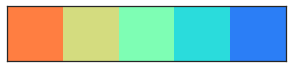

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

sns.set(style = 'white', font_scale=2)

color = sns.color_palette("rainbow_r",5) #PiYG
sns.palplot(color)

In [25]:
def _get_auc(df):
    aucs = []
    for y_true, y_score  in zip(df.y_true, df.y_score):
        auc_value = roc_auc_score(y_true, y_score, average='weighted') # weighted AUC
        aucs.append(auc_value)
    return aucs

(0.4, 1.01)

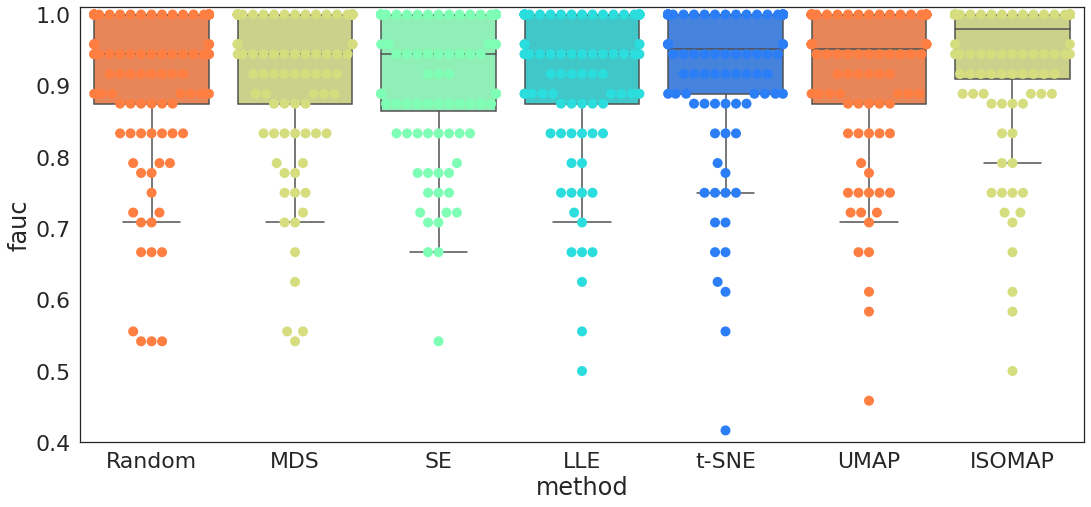

In [26]:
order = ['Random',  'MDS', 'SE', 'LLE', 't-SNE', 'UMAP', 'ISOMAP', ]

adp = dfres.groupby(['method','repeat_seed']).apply(_get_auc).apply(pd.Series)#.#unstack().T.reset_index()
dfres['fauc'] = dfres.apply(lambda x:roc_auc_score(x.y_true, x.y_score, average='weighted'), axis=1)

df = dfres[['method', 'repeat_seed', 'fold', 'fauc']]
fig, ax = plt.subplots(figsize=(18,8))

sns.swarmplot(x='method', y = 'fauc', data = df, palette=color, order=order, ax=ax, size=10)
sns.boxplot(x='method', y = 'fauc', data = df, palette=color, order=order, ax=ax, fliersize=0)
ax.set_ylim(0.4, 1.01)

(0.88, 0.94)

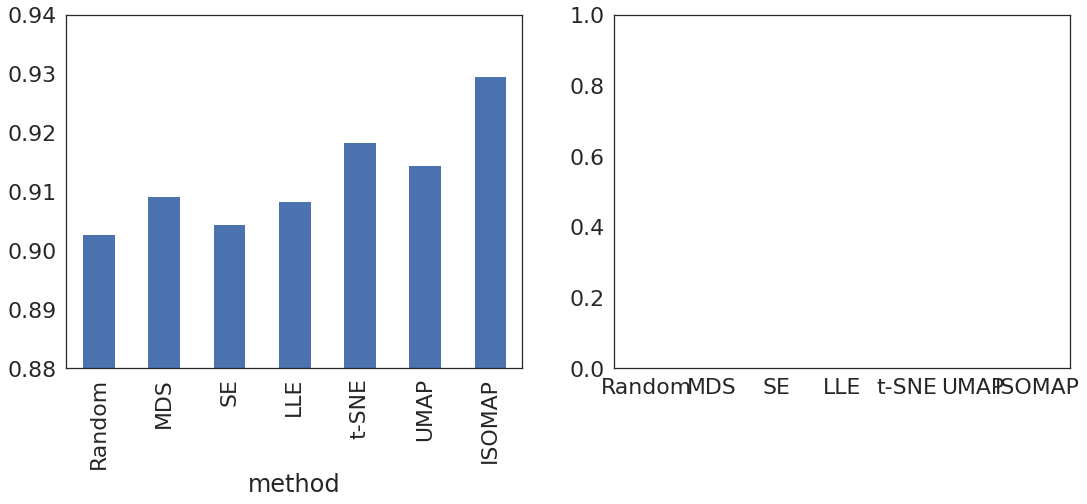

In [28]:
dfp = dfres.groupby(['method','repeat_seed']).apply(_get_auc).apply(pd.Series).mean(axis=1).unstack()

dfp = dfp.loc[order].T


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6.5), sharex=True, )
ax1, ax2 = axes        

dfp.mean().plot(ax=ax1, kind='bar')
ax1.set_ylim(0.88, 0.94)



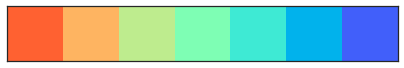

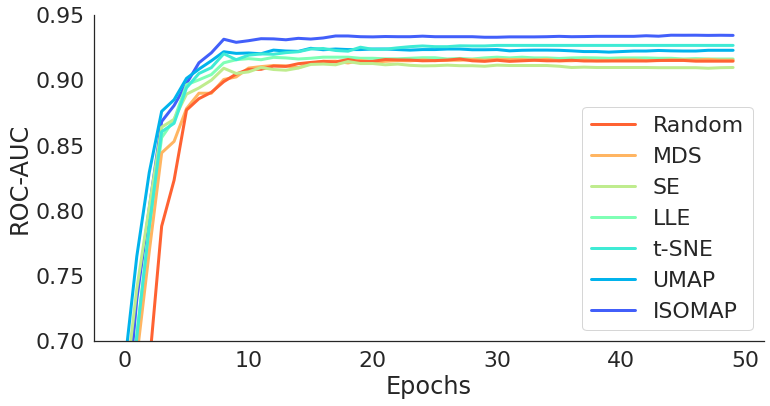

In [29]:
loss  = dfres.groupby(['method', 'repeat_seed'])['val_auc'].apply(lambda x:x.apply(pd.Series).T.mean(axis=1)).reset_index()
ls_mean = loss.groupby(['method', 'level_2'])['val_auc'].mean().reset_index()
ls_std = loss.groupby(['method', 'level_2'])['val_auc'].std().reset_index()
ls_mean['val_auc_std'] = ls_std.val_auc

color = sns.color_palette("rainbow_r", len(Ns)) #PiYG
sns.palplot(color)

order = ['Random',  'MDS', 'SE', 'LLE', 't-SNE', 'UMAP', 'ISOMAP']
cdict = dict(zip(order, color))


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

for i, m in ls_mean.groupby("method"):
    ax.plot(m.level_2, m.val_auc, label = i, color = cdict[i], lw=3)
    #ax.fill_between(m.level_2, m.val_auc - m.val_auc_std, m.val_auc + m.val_auc_std, alpha=0.05)

ax.set_xlabel('Epochs')
ax.set_ylabel('ROC-AUC')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(0.7, 0.95)

handles,labels = ax.get_legend_handles_labels()

ld = dict(zip(labels, handles))

handles = [ld[i] for i in order]
labels = order

ax.legend(handles,labels)

In [ ]:
ax.get_legend_handles_labels()